In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Dense, Input, LSTM
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [0]:
import keras.backend as K
if len(K.tensorflow_backend._get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM

In [0]:
BATCH_SIZE = 64
EPOCHS = 100
EMBEDDING_DIM = 50
MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 100
NUM_SAMPLES = 10000
LATENT_DIM = 256

In [0]:
input_texts = []
target_texts = []
target_input_texts = []

In [7]:
count = 0
with open('/content/gdrive/My Drive/Colab Notebooks/spa.txt') as f:
    for line in f:
        count+=1
        if count > NUM_SAMPLES:
            break
        if '\t' not in line:
            continue
        input_text, translation = line.rstrip().split('\t')
        input_texts.append(input_text)
        target_input_texts.append('<sos> '+translation)
        target_texts.append(translation+' <eos>')
    print('Number of samples %d' % len(input_texts))

Number of samples 10000


In [8]:
tokenizer_inputs = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

word2idx_inputs = tokenizer_inputs.word_index
print('Num of input words %d' % len(word2idx_inputs))

Num of input words 2364


In [0]:
max_len_input = max(len(s) for s in input_sequences)

In [10]:
tokenizer_outputs = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_input_texts)
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_input_sequences = tokenizer_outputs.texts_to_sequences(target_input_texts)

word2idx_outputs = tokenizer_outputs.word_index
print('Num of output words %d' % len(word2idx_outputs))

Num of output words 6294


In [0]:
num_words_output = len(word2idx_outputs) + 1
max_len_target = max(len(s) for s in target_sequences)

In [12]:
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print('encoder_inputs shape: ', encoder_inputs.shape)

encoder_inputs shape:  (10000, 5)


In [13]:
decoder_inputs = pad_sequences(target_input_sequences, maxlen=max_len_target, padding='post')
print('decoder_inputs shape: ', decoder_inputs.shape)

decoder_inputs shape:  (10000, 9)


In [0]:
decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

In [15]:
word2vec = {}
with open('/content/gdrive/My Drive/Colab Notebooks/glove.6B.%sd.txt' % EMBEDDING_DIM) as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
    print('Num of word vectors %d' % len(word2vec))

Num of word vectors 400000


In [16]:
print('Filling pre-trained embeddings..')
num_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)+1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings..


In [0]:
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=max_len_input
)

In [18]:
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(LATENT_DIM, return_state=True)
encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
decoder_inputs_placeholder = Input(shape=(max_len_target,))
decoder_embedding = Embedding(num_words_output, LATENT_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)
decoder_lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [0]:
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [0]:
def batch_generator(batch_size, data_len, encoder_x, decoder_x, decoder_y):
    counter = 0
    while True:
        encoder_i = encoder_x[counter*batch_size:min((counter+1)*batch_size, data_len)]
        decoder_i = decoder_x[counter*batch_size:min((counter+1)*batch_size, data_len)]
        decoder_o = decoder_y[counter*batch_size:min((counter+1)*batch_size, data_len)]
        length = min((counter+1)*batch_size, data_len)-counter*batch_size
        decoder_one_hot = np.zeros((length, max_len_target, num_words_output), dtype='float32')
        for i, d in enumerate(decoder_o):
            for t, word in enumerate(d):
                decoder_one_hot[i, t, word] = 1
        counter+=1
        if counter*batch_size >= data_len:
            counter=0
        yield [encoder_i, decoder_i], decoder_one_hot

In [0]:
random_idx = np.random.randint(0, len(input_texts), len(input_texts))

In [0]:
validation_split = 0.2
validation_size = int(validation_split*len(encoder_inputs))
train_len = len(encoder_inputs)-validation_size

train_idx = random_idx[validation_size:]
valid_idx = random_idx[:validation_size]

In [0]:
train_encoder_input = encoder_inputs[train_idx]
valid_encoder_input = encoder_inputs[valid_idx]

train_decoder_input = decoder_inputs[train_idx]
valid_decoder_input = decoder_inputs[valid_idx]

train_decoder_output = decoder_targets[train_idx]
valid_decoder_output = decoder_targets[valid_idx]

In [0]:
train_gen = batch_generator(BATCH_SIZE, train_len, train_encoder_input, train_decoder_input, train_decoder_output)
valid_gen = batch_generator(BATCH_SIZE, validation_size, valid_encoder_input, valid_decoder_input, valid_decoder_output)

In [26]:
r = model.fit_generator(train_gen,
                       steps_per_epoch=train_len//BATCH_SIZE,
                       epochs=EPOCHS,
                       validation_data=valid_gen,
                       validation_steps=validation_size//BATCH_SIZE)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/100
125/125 [==============================] - 6s 49ms/step - loss: 2.7041 - acc: 0.6451 - val_loss: 2.1982 - val_acc: 0.6960
Epoch 2/100
125/125 [==============================] - 3s 28ms/step - loss: 2.0564 - acc: 0.7010 - val_loss: 1.9966 - val_acc: 0.7133
Epoch 3/100
125/125 [==============================] - 3s 27ms/step - loss: 1.8339 - acc: 0.7197 - val_loss: 1.8412 - val_acc: 0.7278
Epoch 4/100
125/125 [==============================] - 3s 28ms/step - loss: 1.6455 - acc: 0.7371 - val_loss: 1.7168 - val_acc: 0.7451
Epoch 5/100
125/125 [==============================] - 3s 28ms/step - loss: 1.4838 - acc: 0.7532 - val_loss: 1.6191 - val_acc: 0.7579
Epoch 6/100
125/125 [==============================] - 3s 27ms/step - loss: 1.3448 - acc: 0.7687 - val_loss: 1.5478 - val_acc: 0.7678
Epoch 7/100
125/125 [==============================] - 3s 27ms/step - 

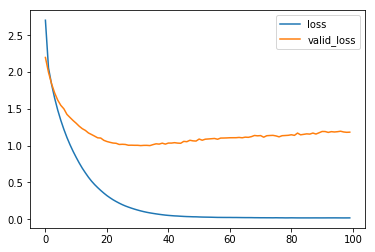

In [27]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='valid_loss')
plt.legend()
plt.show()

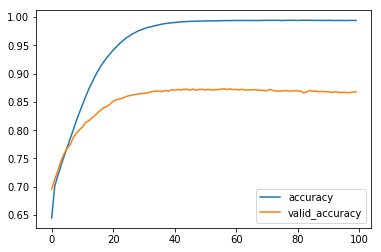

In [28]:
plt.plot(r.history['acc'], label='accuracy')
plt.plot(r.history['val_acc'], label='valid_accuracy')
plt.legend()
plt.show()

In [0]:
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

decoder_state_input_h = Input((LATENT_DIM,))
decoder_state_input_c = Input((LATENT_DIM,))
decoder_states_input = [decoder_state_input_h, decoder_state_input_c]

decoder_input_single = Input((1,))
decoder_input_single_x = decoder_embedding(decoder_input_single)
decoder_outputs, h, c = decoder_lstm(decoder_input_single_x, initial_state=decoder_states_input)
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

In [0]:
decoder_model = Model([decoder_input_single]+decoder_states_input, [decoder_outputs]+decoder_states)

In [0]:
idx2word_eng = {v:k for k,v in word2idx_inputs.items()}
idx2word_trans = {v:k for k,v in word2idx_outputs.items()}

In [0]:
def decode_sequence(input_seq):
    
    states_values = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    
    eos = word2idx_outputs['<eos>']
    
    output_sentence = []
    for _ in range(max_len_target):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_values)
        
        idx = np.argmax(output_tokens[0, 0, :])
        
        if eos == idx:
            break
        
        word = ''
        if idx > 0:
            word = idx2word_trans[idx]
            output_sentence.append(word)
        
        target_seq[0, 0]=idx
        states_value = [h, c]
    
    return ' '.join(output_sentence)

In [33]:
while True:
    i = np.random.choice(len(input_texts))
    input_seq = encoder_inputs[i:i+1]
    translation = decode_sequence(input_seq)
    print('---')
    print('Input: '+input_texts[i])
    print('Translation: '+translation)
    
    ans = input("Continue [Y/n]?")
    if ans and ans.lower().startswith('n'):
        break

---
Input: Tom sang softly.
Translation: tom cantó tom cantó tom cantó tom cantó tom
Continue [Y/n]?y
---
Input: He came running.
Translation: se lo la ¿está en la ¿está en la
Continue [Y/n]?y
---
Input: They'll starve.
Translation: se van a he sentí de te he sentí
Continue [Y/n]?y
---
Input: They know you.
Translation: os conocen.
Continue [Y/n]?y
---
Input: I heard a shout.
Translation: he dicho que me he dicho que me he
Continue [Y/n]?y
---
Input: Start writing.
Translation: de libro.
Continue [Y/n]?n
